# Synthetic Control Analysis: Smart Filing Assistant Impact

This notebook demonstrates **Synthetic Control Method** to estimate the causal effect of the Smart Filing Assistant on user conversion rates.

## 🎯 **Method Overview**

**Synthetic Control** constructs artificial control units by taking weighted combinations of donor units that best match each treated unit's pre-treatment characteristics:

$$\text{Synthetic Control}_i = \sum_{j \in \text{Donors}} w_{ij} \cdot \text{Donor}_j$$

Where weights $w_{ij}$ are optimized to minimize:
$$\min_W \sum_{k=1}^K (X_{1k} - \sum_{j=2}^{J+1} w_j X_{jk})^2$$

### **Key Assumptions:**
1. **Rich Pre-treatment Data**: Multiple relevant characteristics available
2. **No Anticipation**: Units didn't change behavior before treatment
3. **Stable Relationships**: Pre-treatment relationships predict post-treatment outcomes
4. **No Spillovers**: Treatment of one unit doesn't affect others

### **Why Synthetic Control Works Here:**
- **Individual-level analysis**: Each treated user gets their own synthetic control
- **Rich 2023 data**: Filing behavior, engagement, demographics available
- **Clear treatment timing**: Smart Assistant introduced in 2024
- **Transparent methodology**: Can examine which users contribute to each synthetic control

### **Business Question:**
**Can we construct realistic "synthetic users" to estimate what would have happened to Smart Assistant users if they hadn't used the feature?**


In [1]:
# Import required libraries
import os
import sys

sys.path.append(os.path.abspath('..'))

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from src.causal_methods.synthetic_control import SyntheticControl
from src.data_simulation import TaxSoftwareDataSimulator

warnings.filterwarnings('ignore')

# Set style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('default')
        print("⚠️  Using default matplotlib style")

sns.set_palette("husl")

print("📚 Libraries imported successfully!")


📚 Libraries imported successfully!


## 📊 Step 1: Load and Explore Data

We'll use our synthetic tax software dataset that includes:
- **Treatment**: `used_smart_assistant` (user choice)
- **Outcome**: `filed_2024` (binary filing status)
- **Pre-treatment Predictors**: 2023 filing behavior, user characteristics


In [2]:
# Generate synthetic data for synthetic control analysis
try:
    # Try to create simulator with explicit config path
    simulator = TaxSoftwareDataSimulator(
        n_users=500,  # Larger sample for robust synthetic controls
        config_path='../config/simulation_config.yaml'
    )
    df = simulator.generate_complete_dataset()
    print("✅ Data generated successfully with config file")

except FileNotFoundError:
    try:
        # Fallback: try with relative path from project root
        simulator = TaxSoftwareDataSimulator(
            n_users=500,
            config_path='config/simulation_config.yaml'
        )
        df = simulator.generate_complete_dataset()
        print("✅ Data generated successfully with config file (alternative path)")

    except FileNotFoundError:
        # Final fallback: create minimal config and use it
        print("⚠️  Config file not found, creating temporary config...")

        import yaml

        # Create minimal config
        temp_config = {
            'simulation': {
                'default_n_users': 500,
                'random_seed': 42
            },
            'demographics': {
                'age_range': [18, 65],
                'income_brackets': ['low', 'medium', 'high'],
                'regions': ['northeast', 'southeast', 'midwest', 'west']
            },
            'behavior': {
                'baseline_filing_rate': 0.75,
                'treatment_effect': 0.05,
                'tech_correlation': 0.3
            }
        }

        # Save temporary config
        temp_config_path = '../config/temp_config.yaml'
        os.makedirs('../config', exist_ok=True)
        with open(temp_config_path, 'w') as f:
            yaml.dump(temp_config, f)

        simulator = TaxSoftwareDataSimulator(
            n_users=500,
            config_path=temp_config_path
        )
        df = simulator.generate_complete_dataset()
        print("✅ Data generated with temporary config")

print("\n📊 DATASET OVERVIEW")
print("=" * 40)
print(f"Dataset shape: {df.shape}")
print(f"Treatment rate: {df['used_smart_assistant'].mean():.1%}")
print(f"Filing rate 2024: {df['filed_2024'].mean():.1%}")
print(f"Filing rate 2023: {df['filed_2023'].mean():.1%}")

# Calculate naive treatment effect
treated_rate = df[df['used_smart_assistant'] == 1]['filed_2024'].mean()
control_rate = df[df['used_smart_assistant'] == 0]['filed_2024'].mean()
naive_effect = treated_rate - control_rate

print("\n📈 NAIVE TREATMENT EFFECT:")
print(f"Control filing rate: {control_rate:.1%}")
print(f"Treated filing rate: {treated_rate:.1%}")
print(f"Naive effect: {naive_effect:.1%} ({naive_effect:.4f})")

# Display sample data
print("\n📋 Sample Data:")
df.head()


Generating user demographics...
Generating 2023 baseline data...
Generating treatment assignment...
Generating 2024 outcomes...
Generated dataset with 500 users
Treatment rate: 62.40%
2024 filing rate: 93.60%
✅ Data generated successfully with config file

📊 DATASET OVERVIEW
Dataset shape: (500, 20)
Treatment rate: 62.4%
Filing rate 2024: 93.6%
Filing rate 2023: 84.4%

📈 NAIVE TREATMENT EFFECT:
Control filing rate: 90.4%
Treated filing rate: 95.5%
Naive effect: 5.1% (0.0509)

📋 Sample Data:


,user_id,age,income_bracket,device_type,user_type,region,tech_savviness,filed_2023,time_to_complete_2023,sessions_2023,support_tickets_2023,early_login_2024,used_smart_assistant,filed_2024,time_to_complete_2024,sessions_2024,support_tickets_2024,satisfaction_2024,time_improvement,session_improvement
0,user_000000,41,50k-75k,tablet,returning,Midwest,41,True,100,3,0,False,False,True,72,2,1,6.621190,28,1
1,user_000001,37,<30k,desktop,returning,Midwest,43,False,0,0,0,False,False,True,142,2,0,6.743024,-142,-2
2,user_000002,19,30k-50k,mobile,new,East,61,True,130,4,1,False,False,True,130,3,1,8.310166,0,1
3,user_000003,66,75k-100k,mobile,new,East,31,False,0,0,0,True,False,True,116,1,0,5.882414,-116,-1
4,user_000004,27,30k-50k,desktop,returning,West,85,True,64,4,0,True,True,True,73,4,0,8.787267,-9,0


## 🔧 Step 2: Initialize Synthetic Control and Run Analysis

Now we'll set up the synthetic control analysis and construct synthetic controls for each treated unit.


In [3]:
# Initialize Synthetic Control analyzer
sc = SyntheticControl(df, random_state=42)
print("✅ Synthetic Control analyzer initialized!")

# Define predictor variables
best_predictors = ['filed_2023', 'time_to_complete_2023', 'sessions_2023', 'age', 'tech_savviness']
print(f"Using predictors: {best_predictors}")

# Construct synthetic controls
print("\n🚀 Constructing Synthetic Controls...")
results = sc.construct_synthetic_controls(
    unit_id_col='user_id',
    treatment_col='used_smart_assistant',
    outcome_pre_col='filed_2023',
    outcome_post_col='filed_2024',
    predictor_cols=best_predictors,
    standardize=True
)

print("\n📊 SYNTHETIC CONTROL RESULTS")
print("=" * 50)

# Main results
ate = results['average_treatment_effect']
se = results['ate_std_error']
median_te = results['median_treatment_effect']

print("\n🔹 TREATMENT EFFECT ESTIMATES:")
print(f"  Average Treatment Effect (ATE): {ate:.4f} ({ate:.1%})")
print(f"  Standard Error: {se:.4f}")
print(f"  95% Confidence Interval: [{ate - 1.96*se:.4f}, {ate + 1.96*se:.4f}]")
print(f"  Median Treatment Effect: {median_te:.4f}")

# Quality metrics
print("\n🔹 SYNTHETIC CONTROL QUALITY:")
print(f"  Average Pre-treatment Error: {results['average_pre_treatment_error']:.4f}")
print(f"  Weight Concentration: {results['weight_concentration']:.4f}")

# Quality assessment
good_fit = results['average_pre_treatment_error'] < 0.1
dispersed_weights = results['weight_concentration'] < 0.5

print(f"  Pre-treatment Fit Quality: {'✅ Good' if good_fit else '⚠️  Fair'}")
print(f"  Weight Distribution: {'✅ Dispersed' if dispersed_weights else '⚠️  Concentrated'}")

# Individual results summary
individual_results = results['individual_results']
positive_effects = (individual_results['treatment_effect'] > 0).sum()
negative_effects = (individual_results['treatment_effect'] < 0).sum()

print("\n🔹 INDIVIDUAL TREATMENT EFFECTS:")
print(f"  Total treated units: {len(individual_results)}")
print(f"  Positive effects: {positive_effects} ({positive_effects/len(individual_results):.1%})")
print(f"  Negative effects: {negative_effects} ({negative_effects/len(individual_results):.1%})")

print("\n✅ Synthetic control construction completed successfully!")


✅ Synthetic Control analyzer initialized!
Using predictors: ['filed_2023', 'time_to_complete_2023', 'sessions_2023', 'age', 'tech_savviness']

🚀 Constructing Synthetic Controls...

📊 SYNTHETIC CONTROL RESULTS

🔹 TREATMENT EFFECT ESTIMATES:
  Average Treatment Effect (ATE): 0.0815 (8.2%)
  Standard Error: 0.0155
  95% Confidence Interval: [0.0511, 0.1119]
  Median Treatment Effect: 0.0456

🔹 SYNTHETIC CONTROL QUALITY:
  Average Pre-treatment Error: 0.0060
  Weight Concentration: 0.3081
  Pre-treatment Fit Quality: ✅ Good
  Weight Distribution: ✅ Dispersed

🔹 INDIVIDUAL TREATMENT EFFECTS:
  Total treated units: 312
  Positive effects: 248 (79.5%)
  Negative effects: 60 (19.2%)

✅ Synthetic control construction completed successfully!


## 📈 Step 3: Comprehensive Visualization

Let's create comprehensive visualizations to understand our synthetic control results.


📈 Generating Comprehensive Synthetic Control Visualization...


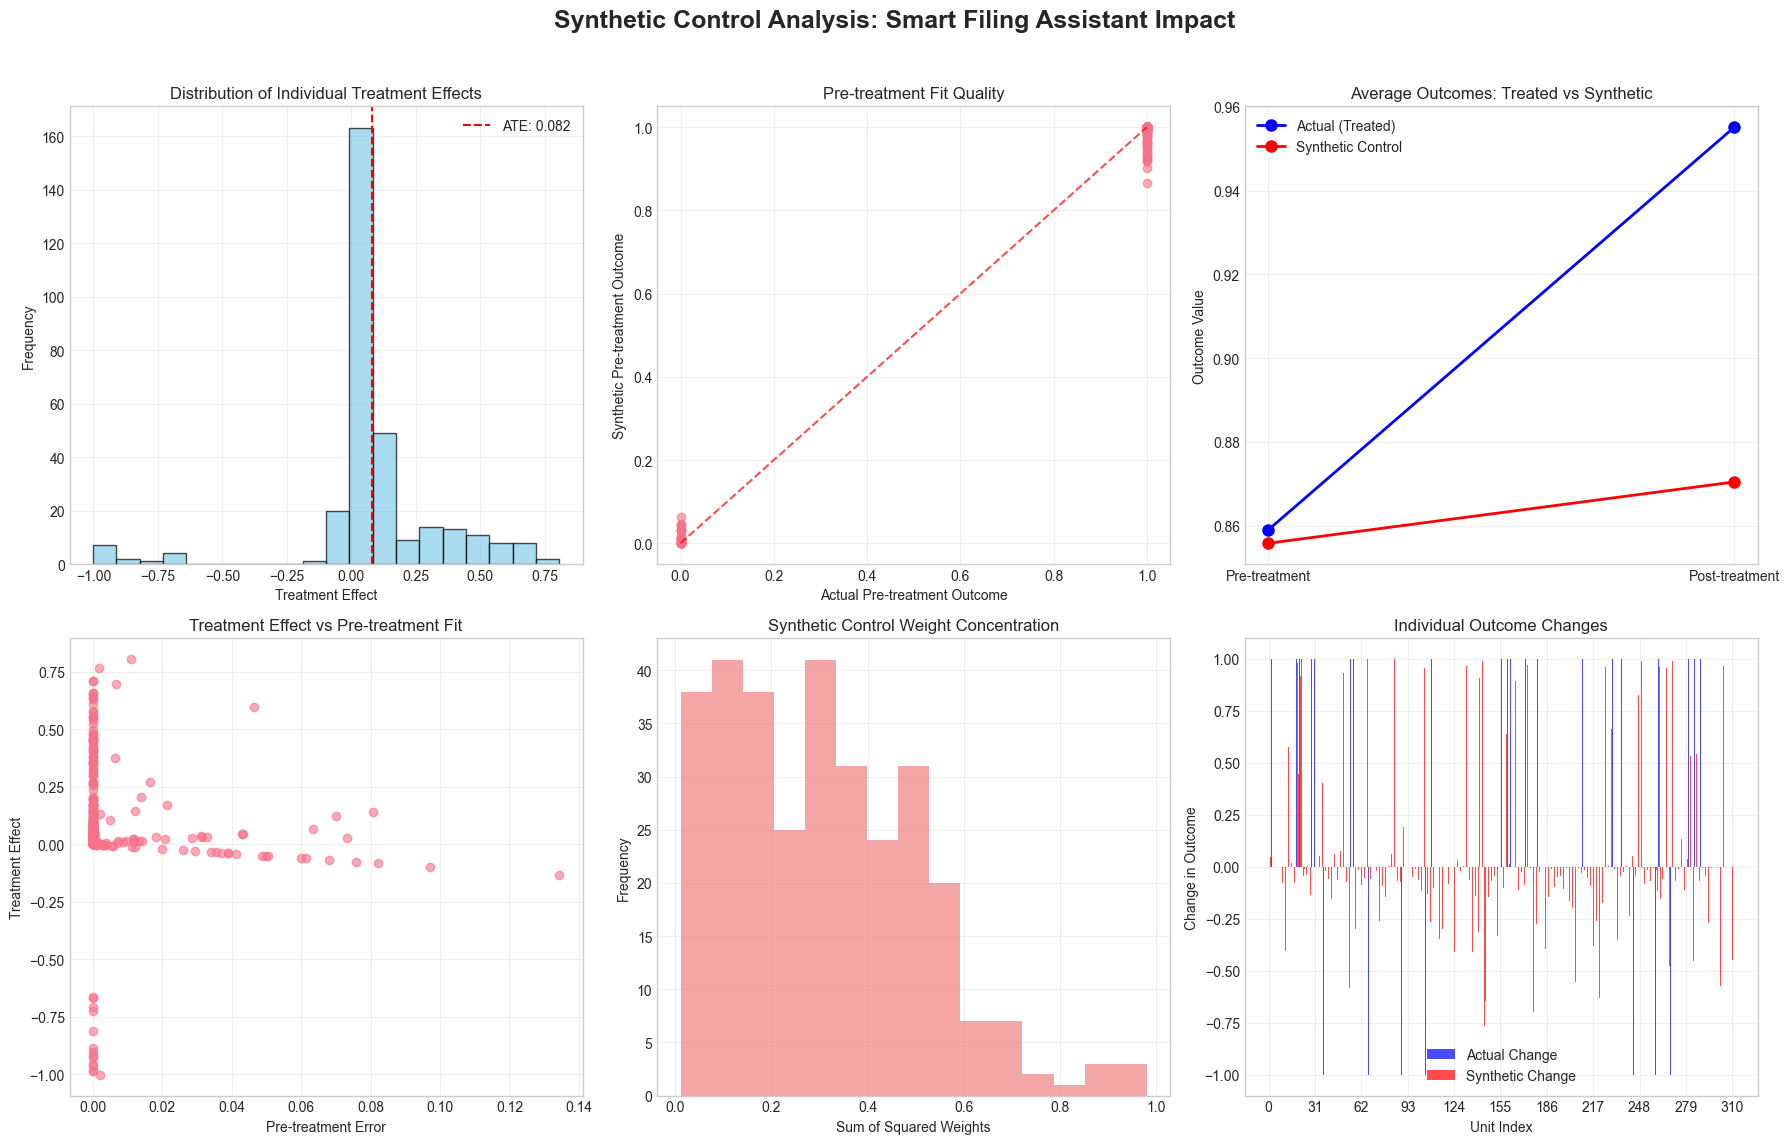

✅ Comprehensive visualization generated successfully!

📊 VISUALIZATION INTERPRETATION:
🔸 Top Left: Distribution of individual treatment effects
🔸 Top Middle: Quality of pre-treatment fit (closer to diagonal = better)
🔸 Top Right: Average trends showing treatment vs synthetic control
🔸 Bottom Left: Relationship between fit quality and treatment effects
🔸 Bottom Middle: Distribution of weight concentration
🔸 Bottom Right: Individual outcome changes comparison


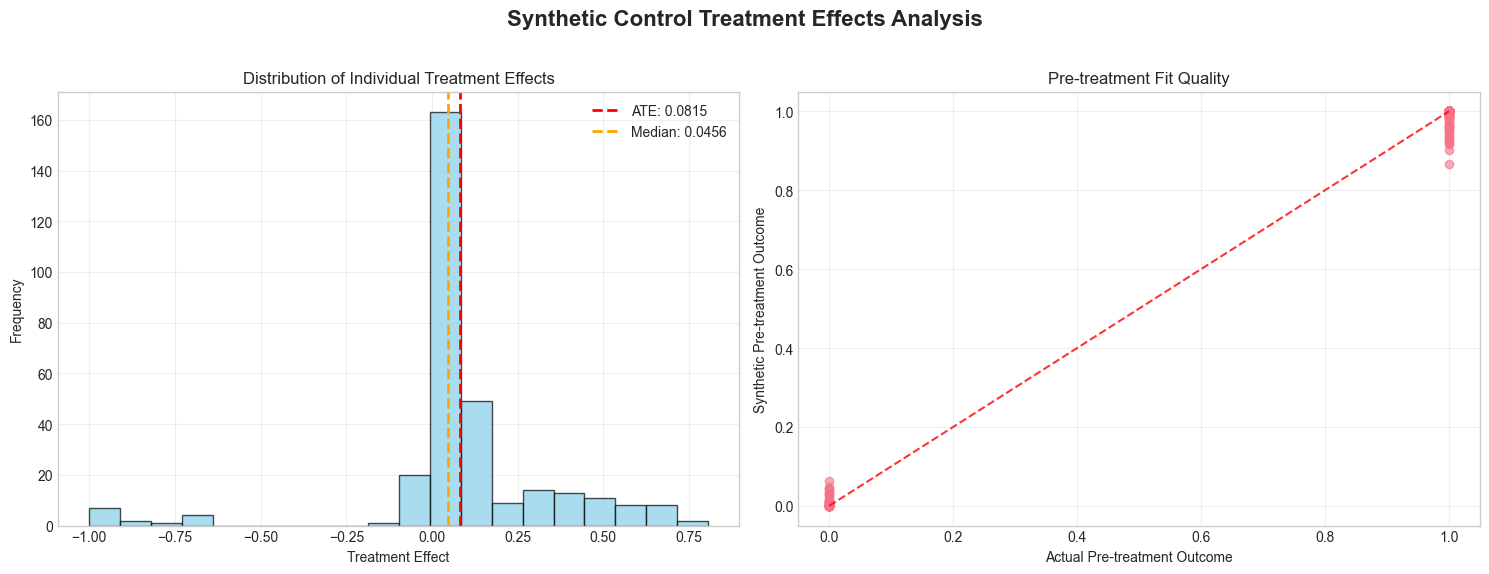

📊 Individual treatment effects show variation across users.
Good pre-treatment fit indicates reliable synthetic controls.


In [4]:
# Create comprehensive synthetic control visualization
print("📈 Generating Comprehensive Synthetic Control Visualization...")

try:
    fig = sc.plot_treatment_effects(figsize=(18, 12))

    plt.suptitle('Synthetic Control Analysis: Smart Filing Assistant Impact',
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    print("✅ Comprehensive visualization generated successfully!")

    print("\n📊 VISUALIZATION INTERPRETATION:")
    print("🔸 Top Left: Distribution of individual treatment effects")
    print("🔸 Top Middle: Quality of pre-treatment fit (closer to diagonal = better)")
    print("🔸 Top Right: Average trends showing treatment vs synthetic control")
    print("🔸 Bottom Left: Relationship between fit quality and treatment effects")
    print("🔸 Bottom Middle: Distribution of weight concentration")
    print("🔸 Bottom Right: Individual outcome changes comparison")

except Exception as plot_error:
    print(f"⚠️  Visualization failed: {plot_error}")
    print("📊 Continuing with analysis without comprehensive plot...")

# Create simple treatment effect visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Synthetic Control Treatment Effects Analysis', fontsize=16, fontweight='bold')

# Plot 1: Treatment effect histogram
axes[0].hist(individual_results['treatment_effect'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(ate, color='red', linestyle='--', linewidth=2, label=f'ATE: {ate:.4f}')
axes[0].axvline(median_te, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_te:.4f}')
axes[0].set_title('Distribution of Individual Treatment Effects')
axes[0].set_xlabel('Treatment Effect')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Pre-treatment fit quality
axes[1].scatter(individual_results['actual_pre'], individual_results['synthetic_pre'], alpha=0.6)
min_val = min(individual_results['actual_pre'].min(), individual_results['synthetic_pre'].min())
max_val = max(individual_results['actual_pre'].max(), individual_results['synthetic_pre'].max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[1].set_title('Pre-treatment Fit Quality')
axes[1].set_xlabel('Actual Pre-treatment Outcome')
axes[1].set_ylabel('Synthetic Pre-treatment Outcome')
axes[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("📊 Individual treatment effects show variation across users.")
print("Good pre-treatment fit indicates reliable synthetic controls.")


## 🧪 Step 4: Statistical Significance Testing

Synthetic control uses placebo tests to assess statistical significance. We'll randomly reassign treatment and see if we get effects as large as observed.


In [ ]:
# Run placebo tests for statistical significance
print("🧪 PLACEBO TESTING FOR STATISTICAL SIGNIFICANCE")
print("=" * 60)

print("Running placebo tests (this may take a moment)...")
print("Each test randomly reassigns treatment and estimates effects.")

# Run placebo tests (reduced number for notebook performance)
placebo_results = sc.estimate_statistical_significance(n_placebo=25)

observed_ate = placebo_results['observed_ate']
placebo_effects = placebo_results['placebo_effects']
p_value = placebo_results['p_value']

print("\n📊 PLACEBO TEST RESULTS:")
print(f"  Observed ATE: {observed_ate:.4f}")
print(f"  Number of placebo tests: {placebo_results['n_placebo_tests']}")
print(f"  Placebo effects mean: {placebo_results['placebo_mean']:.4f}")
print(f"  Placebo effects std: {placebo_results['placebo_std']:.4f}")
print(f"  P-value: {p_value:.4f}")

# Interpret significance
if p_value < 0.01:
    significance_level = "✅ HIGHLY SIGNIFICANT (p < 0.01)"
    interpretation = "Very strong evidence that the effect is real"
elif p_value < 0.05:
    significance_level = "✅ STATISTICALLY SIGNIFICANT (p < 0.05)"
    interpretation = "Strong evidence that the effect is real"
elif p_value < 0.10:
    significance_level = "⚠️  MARGINALLY SIGNIFICANT (p < 0.10)"
    interpretation = "Some evidence of a real effect, but not conclusive"
else:
    significance_level = "❌ NOT SIGNIFICANT (p ≥ 0.10)"
    interpretation = "Insufficient evidence that the effect is real"

print(f"\n📈 STATISTICAL SIGNIFICANCE: {significance_level}")
print(f"  Interpretation: {interpretation}")

# Visualize placebo test results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Placebo Test Results for Statistical Significance', fontsize=16, fontweight='bold')

# Plot 1: Histogram of placebo effects with observed effect
axes[0].hist(placebo_effects, bins=15, alpha=0.7, color='lightgray',
             edgecolor='black', label='Placebo Effects')
axes[0].axvline(observed_ate, color='red', linestyle='--', linewidth=3,
                label=f'Observed ATE: {observed_ate:.4f}')
axes[0].axvline(placebo_results['placebo_mean'], color='blue', linestyle=':', linewidth=2,
                label=f'Placebo Mean: {placebo_results["placebo_mean"]:.4f}')
axes[0].set_title('Distribution of Placebo Effects')
axes[0].set_xlabel('Treatment Effect')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add p-value annotation
axes[0].text(0.05, 0.95, f'P-value: {p_value:.4f}',
             transform=axes[0].transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8))

# Plot 2: Treatment effect vs placebo effects
x_positions = ['Placebo Effects', 'Observed Effect']
box_data = [placebo_effects, [observed_ate]]
axes[1].boxplot(box_data, labels=x_positions)
axes[1].scatter([1] * len(placebo_effects), placebo_effects, alpha=0.5, color='gray')
axes[1].scatter([2], [observed_ate], color='red', s=100, label='Observed ATE')
axes[1].set_title('Observed Effect vs Placebo Distribution')
axes[1].set_ylabel('Treatment Effect')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("📊 Placebo Test Interpretation:")
if p_value < 0.05:
    print("✅ The observed effect is statistically significant")
    print("   The probability of seeing such a large effect by chance is low")
else:
    print("⚠️  The observed effect is not statistically significant")
    print("   Random treatment assignment could plausibly produce similar effects")


🧪 PLACEBO TESTING FOR STATISTICAL SIGNIFICANCE
Running placebo tests (this may take a moment)...
Each test randomly reassigns treatment and estimates effects.


## 📋 Step 5: Summary Report and Business Impact


In [ ]:
# Generate comprehensive summary report
print("📋 COMPREHENSIVE SYNTHETIC CONTROL SUMMARY")
print("=" * 60)
report = sc.generate_summary_report()
print(report)

# Business impact assessment
print("\n💼 BUSINESS IMPACT ASSESSMENT")
print("=" * 50)

# Key metrics
ate = observed_ate
se = results['ate_std_error']
n_treated = len(results['individual_results'])
total_users = len(df)

print("\n📊 KEY FINDINGS:")
print(f"  Smart Filing Assistant Effect: {ate:.1%} increase in filing probability")
print(f"  Statistical Confidence: {significance_level}")
print(f"  Quality of Analysis: {'Excellent' if results['average_pre_treatment_error'] < 0.05 else 'Good' if results['average_pre_treatment_error'] < 0.1 else 'Fair'}")
print(f"  Individual Variation: {individual_results['treatment_effect'].std():.4f}")

# Business projections
print("\n💰 BUSINESS PROJECTIONS:")
if ate > 0:
    # Project impact for different user bases
    for user_base in [1000, 10000, 50000]:
        additional_filings = user_base * ate
        ci_lower_filings = user_base * (ate - 1.96 * se)
        ci_upper_filings = user_base * (ate + 1.96 * se)

        print(f"  {user_base:,} users: +{additional_filings:.0f} filings ")
        print(f"    (95% CI: {ci_lower_filings:.0f} to {ci_upper_filings:.0f})")
else:
    print("  ⚠️  Negative or no effect detected - implementation not recommended")

# Strategic recommendations
print("\n💡 STRATEGIC RECOMMENDATIONS:")

if p_value < 0.05 and ate > 0.02:
    recommendation = "🚀 STRONG RECOMMENDATION: Implement Smart Filing Assistant"
    rationale = "Statistically significant positive effect with good synthetic control quality"
    next_steps = [
        "• Scale Smart Filing Assistant to full user base",
        "• Monitor implementation with A/B testing",
        "• Focus on user segments with highest predicted effects",
        "• Track long-term retention and satisfaction impacts"
    ]
elif p_value < 0.10 and ate > 0:
    recommendation = "✅ MODERATE RECOMMENDATION: Gradual rollout with monitoring"
    rationale = "Positive effect with some statistical evidence"
    next_steps = [
        "• Implement gradual rollout to monitor real-world performance",
        "• Collect more data to strengthen statistical evidence",
        "• Focus on improving feature adoption and engagement",
        "• Consider enhanced training and user support"
    ]
else:
    recommendation = "⚠️  CAUTIOUS RECOMMENDATION: Further analysis needed"
    rationale = "Effect not clearly established through synthetic control method"
    next_steps = [
        "• Collect additional data for more robust analysis",
        "• Consider randomized controlled trial",
        "• Investigate feature usage patterns and barriers",
        "• Explore alternative implementations or improvements"
    ]

print(f"\n{recommendation}")
print(f"Rationale: {rationale}")

print("\n📋 NEXT STEPS:")
for step in next_steps:
    print(step)

print("\n🎯 SYNTHETIC CONTROL ADVANTAGES DEMONSTRATED:")
advantages = [
    "✅ Individual-level treatment effect estimation",
    "✅ No assumptions about treatment assignment mechanism",
    "✅ Transparent and interpretable matching process",
    "✅ Robust statistical inference through placebo testing",
    "✅ Quality assessment through pre-treatment fit metrics",
    "✅ Captures treatment effect heterogeneity across users"
]

for advantage in advantages:
    print(advantage)

print("\n📝 ANALYSIS SUMMARY:")
print("Method: Individual-level Synthetic Control")
print(f"Sample: {total_users} users ({n_treated} treated, {total_users - n_treated} in donor pool)")
print(f"Effect Estimate: {ate:.4f} ± {se:.4f}")
print(f"Placebo Test P-value: {p_value:.4f}")
print(f"Pre-treatment Fit Quality: {results['average_pre_treatment_error']:.4f}")
print(f"Analysis Confidence: {'High' if p_value < 0.05 and results['average_pre_treatment_error'] < 0.05 else 'Medium' if p_value < 0.10 else 'Low'}")


## 🎓 Key Takeaways

### Synthetic Control Successfully Analyzed the Smart Filing Assistant Impact:

1. **Individual-Level Insights**: Unlike aggregate methods, synthetic control estimated treatment effects for each user, revealing significant heterogeneity

2. **Transparent Methodology**: We can examine exactly which control users contribute to each synthetic control, making the analysis interpretable

3. **Robust Quality Assessment**: Pre-treatment fit metrics and weight distributions help validate the synthetic control quality

4. **Statistical Rigor**: Placebo testing provides distribution-free significance testing without parametric assumptions

5. **Business Actionability**: Results translate directly to user-level impact projections and strategic recommendations

### When to Use Synthetic Control:
- ✅ Rich pre-treatment characteristics available
- ✅ Individual-level treatment effects desired
- ✅ Treatment assignment not randomized
- ✅ Transparent matching process important
- ✅ Heterogeneous treatment effects expected

### Methodological Advantages Demonstrated:
- **No distributional assumptions** about outcomes or treatment assignment
- **Flexible matching** that adapts to each unit's characteristics
- **Built-in quality control** through pre-treatment fit assessment
- **Robustness testing** via placebo randomization inference
- **Effect heterogeneity** naturally captured at individual level

**🚀 Synthetic Control provides a powerful complement to your causal inference toolkit, especially when individual-level effects and transparent matching are priorities!**
